In [1]:
# import all the libraries needed to create the language models and generate text
import random
import pandas as pd
import string
from nltk import trigrams, bigrams, ngrams
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt 

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [2]:
# read the dataset file and show the first 10 rows
df = pd.read_csv("lyrics.csv")
df.head(10)

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."
5,5,all-i-could-do-was-cry,2009,beyonce-knowles,Pop,I heard\nChurch bells ringing\nI heard\nA choi...
6,6,once-in-a-lifetime,2009,beyonce-knowles,Pop,This is just another day that I would spend\nW...
7,7,waiting,2009,beyonce-knowles,Pop,"Waiting, waiting, waiting, waiting\nWaiting, w..."
8,8,slow-love,2009,beyonce-knowles,Pop,[Verse 1:]\nI read all of the magazines\nwhile...
9,9,why-don-t-you-love-me,2009,beyonce-knowles,Pop,"N-n-now, honey\nYou better sit down and look a..."


In [3]:
# show information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362237 entries, 0 to 362236
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   index   362237 non-null  int64 
 1   song    362235 non-null  object
 2   year    362237 non-null  int64 
 3   artist  362237 non-null  object
 4   genre   362237 non-null  object
 5   lyrics  266557 non-null  object
dtypes: int64(2), object(4)
memory usage: 16.6+ MB


In [4]:
# find the unique values of specified columns 
print("The unique genres in the dataset are: ")
print(df["genre"].unique())
print("The number of artists in the dataset is: "+ str(len(df["artist"].unique())))

The unique genres in the dataset are: 
['Pop' 'Hip-Hop' 'Not Available' 'Other' 'Rock' 'Metal' 'Country' 'Jazz'
 'Electronic' 'Folk' 'R&B' 'Indie']
The number of artists in the dataset is: 18231


The value counts for each genre is: 
Rock             131377
Pop               49444
Hip-Hop           33965
Not Available     29814
Metal             28408
Other             23683
Country           17286
Jazz              17147
Electronic        16205
R&B                5935
Indie              5732
Folk               3241
Name: genre, dtype: int64


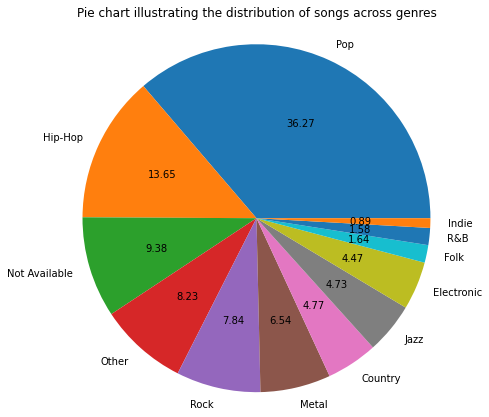

In [5]:
# visualise the distribution of the genres
print("The value counts for each genre is: ")
print(df["genre"].value_counts())
plt.pie(df["genre"].value_counts(), labels=df["genre"].unique(), autopct="%.2f", radius=2)
plt.title("Pie chart illustrating the distribution of songs across genres", x=0.5, y=1.4)
plt.show()

The top 10 artists with the most songs in the dataset: 
dolly-parton        755
american-idol       700
elton-john          680
b-b-king            667
chris-brown         655
eddy-arnold         628
barbra-streisand    624
ella-fitzgerald     623
bob-dylan           614
david-bowie         599
Name: artist, dtype: int64


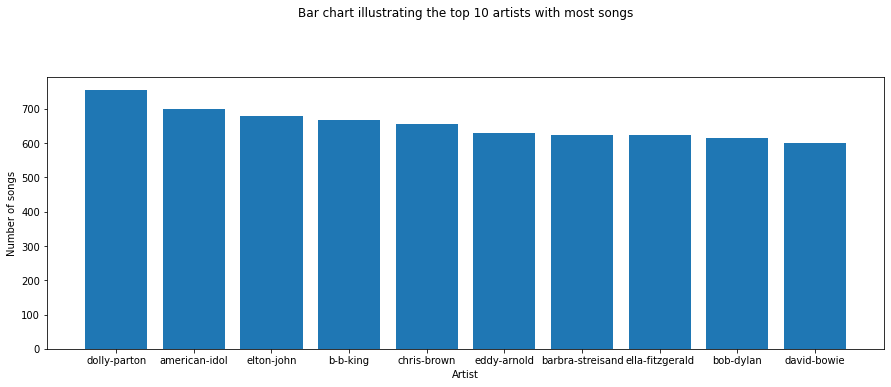

In [6]:
# visualising the data of the artists and their songs
print("The top 10 artists with the most songs in the dataset: ")
print(df["artist"].value_counts().head(10))
plt.figure(figsize=(15,5))
plt.bar(df["artist"].value_counts().head(10).index, df["artist"].value_counts().head(10))
plt.title("Bar chart illustrating the top 10 artists with most songs", x=0.5, y=1.2)
plt.xlabel("Artist")
plt.ylabel("Number of songs")
plt.show()

In [7]:
# this method picks random songs from the dataset
def randomLyrics(dataFrame):
    number_of_songs = 250
    # stores the indices of the songs to use
    chosen_songs = list() 
    # stores the lyrics of the songs
    selected_data = list()
    for _ in range(0, number_of_songs):
        # choose random number which signifies the index of the song to be picked
        n = random.randint(0, len(dataFrame["index"]))
        # check if the index wasn't picked before
        while n in chosen_songs:            
            n = random.randint(0, len(dataFrame["index"]))
        chosen_songs.append(n)
    # concatenate the lyrics of each value in chosen songs
    for i in chosen_songs:
        selected_data += dataFrame.loc[dataFrame["index"] == i]["lyrics"].tolist()
    return selected_data

In [8]:
# get user input on the options of generation
# the user will be asked to choose either generate in default without no restrictions
# generate based on an artist 
# or generate based on a genre
def userChoice(df):
    userInput = int(input("Please choose one of the following options: 1- General generation with no restrictions. "+
                        "\n 2- Generate based on a certain artist. \n 3- Generate based on a specific genre.\n"))
    # store the lyrics
    selected_data = list() 
    # user chooses to generate lyrics with no restrictions
    if(userInput == 1):
        selected_data = randomLyrics(df)
    # user chooses to generate based on a certain artist
    # if the artist provided is not in the dataset the method will return an empty list
    elif(userInput == 2):
        artist = input("Please choose an artist: (Suggested artists: asap-rocky, future, down, ariana-grande, elysium)")
        if len(df.loc[df["artist"] == artist]) <= 250:
            selected_data = df.loc[df["artist"] == artist]["lyrics"].tolist()
        else: 
            # if the data is more than 250 songs than select a few of those songs
            selected_data = randomLyrics(df.loc[df["artist"] == artist])
    # user chooses to generate based on a certain genre
    elif(userInput == 3):
        genre = input("Please choose a genre: (Available genres: Hip-Hop, Folk, Metal, Jazz, Pop, Indie, Electronic, Rock, Country, Other, R&B)")
        if len(df.loc[df["genre"] == genre]) <= 250:
            selected_data = df.loc[df["genre"] == genre]["lyrics"].tolist()
        else: 
            # if the data is more than 250 songs than select a few of those songs
            selected_data = randomLyrics(df.loc[df["genre"] == genre])
    else:
        print("Please choose 1, 2, or 3")
    return selected_data

lyrics = userChoice(df)

In [9]:
# Some rows might be empty so we need to ignore them
print("Number of songs selected: "+ str(len(lyrics)))
lyrics = [x for x in lyrics if not isinstance(x, float)]
# length of the lyrics list after the removal
print("Actual number of songs to be used: "+ str(len(lyrics)))

Number of songs selected: 211
Actual number of songs to be used: 180


In [10]:
# join the songs in the lyrics as one big string
data = " ".join(lyrics)
# print the first 400 characters
print(data[:400])

Dirty soda, Spike Lee, white girl, iced tea
Fully loaded AP, yeah
I just fucked your bitch in some Gucci flip flops
I just had some bitches and I made them lip lock
I just took a piss and I seen codeine coming out
We got purple Activis, I thought it was a drought
Bitch I'ma choose the dirty over you
You know I ain't scared to lose you
They don't like it when you're telling the truth
I'd rather be 


In [11]:
# this method removes punctuation from text
# and turns it to lower case then returns the clean text

def clean_data(text):
    table = str.maketrans('', '', string.punctuation)
    new_text = text.translate(table)
    tokens = new_text.split()
    tokens = [word for word in tokens if word.isalpha() or word.isnumeric()]
    tokens = [word.lower() for word in tokens]
    return " ".join(tokens)

In [12]:
# use the cleaned data to check all the special characters in the text
# this helps us to recognise any uncommon characters that we might not want to keep in our text
# such as other languages symbols and other symbols that dont really contribute to the meaning

# split the data into sentences
sentences = data.split("\n")
# clean the sentences
data = [clean_data(sentence) for sentence in sentences]
# print the first 5 sentences
print("The first 5 sentences: ")
print(data[:5])
# join the lyrics after they after being cleaned 
corpus = "".join(data)
# print the unique characters found in the lyrics selected
print("unique_chars:", sorted(set(corpus)))

The first 5 sentences: 
['dirty soda spike lee white girl iced tea', 'fully loaded ap yeah', 'i just fucked your bitch in some gucci flip flops', 'i just had some bitches and i made them lip lock', 'i just took a piss and i seen codeine coming out']
unique_chars: [' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'º', 'ã']


In [13]:
# remove characters other than English characters 
new_data = []
for sentence in data: 
    sentence = sentence.encode("ascii", "ignore").decode()
    new_data.append(sentence)
corpus = " ".join(new_data)
# print the new unique characters after removing the non English characters
print("unique_chars:", sorted(set(corpus)))
# number of characters after removal
print("Number of characters after removal: "+ str(len(corpus)))
# print the first 200 characters 
print("first 200 characters: " + corpus[:200])

unique_chars: [' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Number of characters after removal: 467976
first 200 characters: dirty soda spike lee white girl iced tea fully loaded ap yeah i just fucked your bitch in some gucci flip flops i just had some bitches and i made them lip lock i just took a piss and i seen codeine c


In [14]:
# printing the most common words in the corpus
counter = Counter(corpus.split())
most_occur = counter.most_common(5)
# print the top 5 most occuring words
print(most_occur)

[('i', 4040), ('the', 3313), ('a', 2871), ('you', 2443), ('that', 1740)]


In [15]:
# Creating the bigram model
tokens = corpus.split()
# create the placeholder for the model
bigram_model = defaultdict(lambda: defaultdict(lambda: 0))
# generate the bigrams of our corpus
corpus_bigrams = list(bigrams(tokens, pad_right=True, pad_left=True))
# fill the model / the defaultdicts with the word sequences from the bigrams 
for word1, word2 in corpus_bigrams:
    bigram_model[word1][word2] += 1

# transform the counts to probabilities
for word in bigram_model:
    total_counts = float(sum(bigram_model[word].values()))
    for following_word in bigram_model[word]:
        bigram_model[word][following_word] /= total_counts
# this will show how the words that can come after a certain word and their probabilities are stored
dict(bigram_model["i"])

{'just': 0.04554455445544554,
 'made': 0.008663366336633664,
 'seen': 0.006683168316831683,
 'thought': 0.004702970297029703,
 'aint': 0.034900990099009904,
 'had': 0.018564356435643563,
 'called': 0.0009900990099009901,
 'sold': 0.0009900990099009901,
 'dont': 0.048514851485148516,
 'take': 0.005693069306930693,
 'never': 0.007920792079207921,
 'was': 0.02995049504950495,
 'came': 0.01410891089108911,
 'strapped': 0.0004950495049504951,
 'gave': 0.0024752475247524753,
 'put': 0.00891089108910891,
 'told': 0.03440594059405941,
 'got': 0.07846534653465347,
 'need': 0.007920792079207921,
 'try': 0.0024752475247524753,
 'pull': 0.005198019801980198,
 'smoke': 0.0017326732673267327,
 'get': 0.01782178217821782,
 'can': 0.020792079207920793,
 'float': 0.0004950495049504951,
 'pour': 0.0034653465346534654,
 'been': 0.012623762376237625,
 'go': 0.010643564356435644,
 'fucked': 0.0032178217821782176,
 'jumped': 0.0027227722772277226,
 'step': 0.0017326732673267327,
 'come': 0.00396039603960396

In [16]:
# Creating a trigram model
# create the placeholder for the model
trigram_model = defaultdict(lambda: defaultdict(lambda: 0))
# generate the trigrams of our corpus
corpus_trigrams = list(trigrams(tokens, pad_right=True, pad_left=True))
# fill the model / the defaultdicts with the word sequences from the trigrams 
for word1, word2, word3 in corpus_trigrams:
    trigram_model[(word1, word2)][word3] += 1
# transform the counts to probabilities
for two_words in trigram_model:
    total_counts = float(sum(trigram_model[two_words].values()))
    for following_word in trigram_model[two_words]:
        trigram_model[two_words][following_word] /= total_counts


In [17]:
# create an ngram model (n will be specified by the user)
# create the placeholder for the model
quadgram_model = defaultdict(lambda: defaultdict(lambda: 0))
# generate the bigrams of our corpus
corpus_fourgrams = list(ngrams(tokens, 4, pad_right=True, pad_left=True))
# fill the model / the defaultdicts with the word sequences from the bigrams 
for word1, word2, word3, word4 in corpus_fourgrams:
    quadgram_model[(word1, word2, word3)][word4] += 1
# transform the counts to probabilities
for three_words in quadgram_model:
    total_counts = float(sum(quadgram_model[three_words].values()))
    for following_word in quadgram_model[three_words]:
        quadgram_model[three_words][following_word] /= total_counts


In [18]:
# function to generate 200 words using bigram model
def generate_lyrics_using_bigrams(first_input):
    # first_word = a.get()
    text = [first_input]
    text_length = 0
    
    # check if the number of words generated is less than 200 and that the word chosen has words
    # that can come after it based on the data 
    while text_length<=200 and len(bigram_model[text[len(text)-1]].keys()) != 0:
        # select a random probability threshold  
        r = random.random()
        # this signifies the threshold 
        accumulator = .0
        for word in bigram_model[text[-1]].keys():
            accumulator += bigram_model[text[-1]][word]
            # select words that are above the probability threshold
            if accumulator >= r:
                text.append(word)
                text_length+=1
                break
    return text

# ask the user to choose a word to start generating lyrics 
first_input = input("Enter the word to start generating lyrics: ")
bigrams_result = generate_lyrics_using_bigrams(first_input)
# if the word picked is not in the data then the program will use the word with the most occurences
if (len(bigrams_result) == 1):
    print("The input you provided was not found in the dataset.")
    print("the program used the word with the mostg occurences as a replacemenet, the word is: " + most_occur[0][0])
    bigrams_result = generate_lyrics_using_bigrams(most_occur[0][0])
# join the words generated into one string
temp = " ".join(bigrams_result)
print("The song generated is: \n" + temp + ".")    

The song generated is: 
i get too obsessed with a whole nother hunned bottles nigga move that playin you smell like it baby ill spend a dealer forreal haha hahaha young young nigga i made myself a dope young nigga i party affection is homicide unit tryna hear da woolie im bout to pour it again and see nobody im the greatest aog in your past start acting you want we dont trust my chains to get money just took a cake on tits now its cotton money like i gotta real niggas split it nigga you wishing we goin ape im runnin runnin to run it up tryna see is a beamer then she the memories now that coke in money this for er im just bought a benz bitch who was serving piles where im from got some space cadets and youre loyal i wasnt gon do shit up before niggas getting higher than ohio get it down south side i blow a film movie nigga like she want no ho to get the syrup send er i seen codeine in money with a spider young nigga grindin and cold got em fuck up an astronaut forever ever i used to thi

In [19]:
# function to generate 200 words using trigram model
def generate_lyrics_using_trigrams(first_word, second_word):
    text = [first_word, second_word]
    text_length = 0
    
    # check if the number of words generated is less than 200 and that the words chosen have words
    # that can come after it based on the data
    while text_length<=200 and len(trigram_model[tuple(text[-2:])].keys()) != 0:
        # select a random probability threshold  
        r = random.random()
        accumulator = 0

        for word in trigram_model[tuple(text[-2:])].keys():
            accumulator += trigram_model[tuple(text[-2:])][word]
            # select words that are above the probability threshold
            if accumulator >= r:
                text.append(word)
                text_length+=1
                break
    return text

# ask the user to choose two words to start generating lyrics
# the two words should be seperated by a space and not have a space after the second word
first_input, second_input = input("Enter two words to start generating lyrics: ").split()
trigrams_result = generate_lyrics_using_trigrams(first_input, second_input)
# if the words chosen are not in the dataset, the output would be empty
if (len(trigrams_result) == 2):
    print("The inputs you chose were not found in the dataset.")
else:
    temp = " ".join(trigrams_result)
    print("The song generated is: \n" + temp + ".")

The song generated is: 
i love to a hunned bottles nigga you aint even trynna be special i bag bitches burkin bag on ya future and never turn on the lights im lookin for a watch it happen it is my only damn purpose hook getting to the side i hit the south i got all the same mentality when i suffer i got love in the cold got fifty eight grams of bar im servin dope js in the couch and tell her legs open sesame abracadabra she wet for me like i got a hunnit racks bustin out the gym im bout to shoot it shoot it shoot out the van you know its one of you bitches we dont want no bitch who need to get tippy smokin reminiscin underground king pimp c bun b yeea gone show the swagga astronaut forever rockstar mcjagger yeea imma set my trend again put spikes on louis v tycoon you aint even started drinking beer yet they bust the dashboard hold up hold up on the moon turn on the purple and the drank and the hummer fronting some crack in the bed she bring that twerkalator make sure when you was serv

In [20]:
# function to generate 200 words using trigram model
def generate_lyrics_using_quadgrams(first_word, second_word, third_word):
    text = [first_word, second_word, third_word]
    text_length = 0

    # check if the number of words generated is less than 200 and that the words chosen have words
    # that can come after it based on the data
    while text_length<=200 and len(quadgram_model[tuple(text[-3:])].keys()) != 0:
        # select a random probability threshold  
        r = random.random()
        accumulator = 0
        for word in quadgram_model[tuple(text[-3:])].keys():
            accumulator += quadgram_model[tuple(text[-3:])][word]
            # select words that are above the probability threshold
            if accumulator >= r:
                text.append(word)
                text_length+=1
                break
    return text

# ask the user to choose three words to start generating lyrics
# the three words should be seperated by a space and not have a space after the third word
first_input, second_input, third_input = input("Enter three words to start generating lyrics: ").split()
quadgrams_result = generate_lyrics_using_quadgrams(first_input, second_input, third_input)
# if the words chosen are not in the dataset, the output would be empty
if (len(quadgrams_result) == 3):
    print("The inputs you chose were not found in the dataset.")
else:
    temp = " ".join(quadgrams_result)
    print("The generated song is:~ \n" + temp + ".")

The inputs you chose were not found in the dataset.


Recurrent Neural Networks model

In [21]:
# Store all the unique characters in a List to cerate a mapping dictionary
corpus = (" ".join(tokens)).strip()
chars = sorted(list(set(corpus)))

# store the length of the corpus
corpus_length = len(corpus)
# store the number of unique characters 
chars_length = len(chars)

# map each characters in chars to a number
chars_to_nums = dict((char, i) for i, char in enumerate(chars))
# reverse mapping
nums_to_chars = dict((i, c) for i, c in enumerate(chars))

print("The Length of our corpus is: {}".format(corpus_length))
print("The Number of unique characters in our corpus is: {}".format(chars_length))

The Length of our corpus is: 467963
The Number of unique characters in our corpus is: 37


In [22]:
# this function splits the corpus into equal length strings and maps the characters in the sequences to numbers
length = 30
def create_sequences(text):
    sequences = []
    for i in range(length, len(text)):
        # select sequence of characters and store them
        # each sequence will be of length 31
        c = text[i-length:i+1]
        sequences.append(c)
    print("Total number of sequences in the Corpus: ", len(sequences))
    # print the first sequence
    print(sequences[0])
    return sequences
    
sequences = create_sequences(corpus)

Total number of sequences in the Corpus:  467933
dirty soda spike lee white girl


In [23]:
# This function loops through the sequences and map their characters to numbers
def map_sequences(sequences):
    x_data = []
    y_data = []
    # for each character in the dictionary we retrieve its corresponding number
    # and then append it to the empty lists we created
    for seq in sequences:
        sequence = [chars_to_nums[char] for char in seq]
        # store the encoded sequence
        x_data.append(sequence[:len(sequence)-1])
        y_data.append(sequence[len(sequence)-1])
    return x_data, y_data

In [24]:
x_data, y_data = map_sequences(sequences)
# Example:
print("The first encoded sequence is: ", x_data[0])
print("The character that comes after this sequence is: ", y_data[0])

# converting the input into a numpy array to feed into the network
X = np.reshape(x_data, (len(x_data), length, 1))
X = X/float(chars_length)

# one hot encode the y data
y_data = np_utils.to_categorical(y_data, num_classes=chars_length)

The first encoded sequence is:  [14, 19, 28, 30, 35, 0, 29, 25, 14, 11, 0, 29, 26, 19, 21, 15, 0, 22, 15, 15, 0, 33, 18, 19, 30, 15, 0, 17, 19, 28]
The character that comes after this sequence is:  22


In [25]:
# create the LSTM model / initialise the model
model = Sequential()

# add an LSTM layer
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
# to help prevent overfitting, we used a dropout layer
model.add(Dropout(0.2))

# Add Output Layer
model.add(Dense(y_data.shape[1], activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')
# display the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 37)                9509      
                                                                 
Total params: 273,701
Trainable params: 273,701
Non-trainable params: 0
_________________________________________________________________


In [26]:
# fit the model
model.fit(X, y_data, epochs=20)

Epoch 1/20


In [ ]:
# pick a random sequence from the data to start generating text
num = random.randint(0, len(x_data)-1)
starting_text = x_data[num]
# number encoded sequence
print(starting_text)

# the starting string as a string of characters
print("".join([nums_to_chars[num] for num in starting_text]))
# This function generates text from model created
def Lyrics_Generator(starting_text, char_count):
    generated_text = "".join([nums_to_chars[num] for num in starting_text])
    for _ in range(char_count):
        x = np.reshape(starting_text, (1, length, 1))
        x = x / float(chars_length)
        prediction =  model.predict(x, verbose=0)
        index = np.argmax(prediction)
        next_char = nums_to_chars[index]
        # generating the new text
        generated_text += next_char
        starting_text.append(index)
        starting_text = starting_text[1:]
    return generated_text

[35, 25, 31, 28, 0, 23, 25, 24, 15, 35, 0, 31, 26, 0, 19, 0, 17, 25, 30, 30, 11, 0, 29, 30, 11, 13, 21, 0, 30, 18]
your money up i gotta stack th


In [ ]:
song = Lyrics_Generator(starting_text, 1500)
print("The generated song is: " + song + ".")

The generated song is: your money up i gotta stack th toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe toe to

In [ ]:
reference = random.choice(lyrics)
print(reference)

The thing I like about you
Is the way you
The way that you do
The thing I like about you
God or the Devil alone
Could not have made you up
The two must have worked
As one together
So good just wanna eat you up
Nothing like the real thing
Lick your sticky fingers boy
And sing for your dinner sing
Come on pretty baby
Make me lose my mind
Everybody get together
Gonna make love shine
[Chorus]
Do you know what it is
To feel the light of love inside you
And all the darkness falls away
If you feel the way I feel
Then I believe we have the answer
I've been searching for tonight
Love me baby, love me baby
Shake me like a monkey, baby
Forever I'm yours, yours, yours
Yeah forever I am
I, I, I
Can't stop thinking 'bout you
Yeah Yeah Yeah
Why would I want to
I like my coffee
With toast and jelly
But I'd rather be licking
From your back to your belly
I, I, I
Think that I'm going to
[Chorus]
Cigarettes and coffee
Broken hearts and being lonely
Little girls and ponies
Things that go together
Yes and n

In [ ]:
# Using ROUGE metric for evaluation 
from rouge import Rouge 
model_out = " ".join(bigrams_result)
rouge = Rouge()
rouge.get_scores(model_out, reference, avg=True)

{'rouge-1': {'r': 0.17006802721088435,
  'p': 0.15822784810126583,
  'f': 0.16393442123601196},
 'rouge-2': {'r': 0.016666666666666666,
  'p': 0.020202020202020204,
  'f': 0.0182648352286246},
 'rouge-l': {'r': 0.08163265306122448,
  'p': 0.0759493670886076,
  'f': 0.07868851959666788}}

In [ ]:
rouge = Rouge()
rouge.get_scores(" ".join(trigrams_result), reference)

[{'rouge-1': {'r': 0.14965986394557823,
   'p': 0.16417910447761194,
   'f': 0.1565836249039401},
  'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
  'rouge-l': {'r': 0.07482993197278912,
   'p': 0.08208955223880597,
   'f': 0.07829180995732103}}]

In [ ]:
rouge = Rouge()
rouge.get_scores(" ".join(quadgrams_result), reference)

[{'rouge-1': {'r': 0.013605442176870748,
   'p': 0.6666666666666666,
   'f': 0.026666666274666666},
  'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
  'rouge-l': {'r': 0.013605442176870748,
   'p': 0.6666666666666666,
   'f': 0.026666666274666666}}]

In [ ]:
rouge = Rouge()
rouge.get_scores(song, reference)

[{'rouge-1': {'r': 0.013605442176870748, 'p': 0.25, 'f': 0.025806450633923034},
  'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
  'rouge-l': {'r': 0.006802721088435374,
   'p': 0.125,
   'f': 0.012903224827471457}}]